## Comparing DLC Camera CSV 3D coordinate Data to Autobender/Rotary Encoder

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from config import path_to_repository
from analysis import DLC3DBendAngles
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [7]:
#load rotary encoder csv, camera 3d data form DLC csv, and flir_data.mat with timestamps from python camera acquisition
trial_string = "41_19_B" # choose from 24_57, 29_07, 31_23, 33_22, 35_22, 37_05
# REMEMBER to change valley and peak ranges/inte-peak distance below based on trial

signed_angles = True # whether to compute signed angles (True) or unsigned angles (False)

# renc = os.path.join(path_to_repository , f'/Volumes/ExtremeSSD/SNEL/camera_data/experimental_data_2025_08_20_20_06_02/sensor_data/2025_08_20_18_{trial_string}/data_rotenc_2025_08_20_18_{trial_string}.csv')
# df_renc = pd.read_csv(renc)  
# # cam = os.path.join(path_to_repository , '/Volumes/ExtremeSSD/SNEL/camera_data/8.22 calib/videos_and_analyzed_3D/2025_08_20_18_24_57_DLC_3D.csv')
cam_3d_path = os.path.join(path_to_repository , f'/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/videos_DLCpred/2025_09_09_12_{trial_string}_DLC_3D.csv')
cam_timestamp = os.path.join(
    path_to_repository,
    f'/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_12_{trial_string}/flir_data_2025_09_09_12_{trial_string}.mat'
)

# temp_save_dir = os.path.join(path_to_repository , '/Users/phily/Developer/sensorimotor-lab/Strain-Sensor-/Code/analysis/temp_plots')
# if not os.path.exists(temp_save_dir):
#     os.makedirs(temp_save_dir)
    


In [22]:

class CameraData:
    def __init__(self, csv_path, flir_mat_path):
        self.csv_path = os.path.join(path_to_repository , csv_path) # DLC 3D triangulated points
        self.timestamp_path = os.path.join(path_to_repository , flir_mat_path) # timestamps from python camera acquisition
        self.cam = DLC3DBendAngles(self.csv_path)
        self.df_ts = self.cam.load_mat_as_df(self.timestamp_path, prefix="ts")
        rows_cam, rows_ts = DLC3DBendAngles.compare_row_counts(self.cam.df, self.df_ts)
        if rows_cam != rows_ts:
                print(f"Warning: Number of rows in camera data ({rows_cam}) does not match number of timestamps ({rows_ts}).")
        self.cam.add_dataframe(self.df_ts)
        
        # Calculate bend angles from DLC 3d trianglulated data
        # --- MCP bend ---
        hand_pts = self.cam.get_points("hand")
        mcp_pts  = self.cam.get_points("MCP")
        pip_pts  = self.cam.get_points("PIP")

        v1_mcp = self.cam.vector(hand_pts, mcp_pts)  # hand→MCP
        v2_mcp = self.cam.vector(mcp_pts, pip_pts)   # MCP→PIP
        ref = np.array([0,0,1])
        signed_angles = False
        self.angles_mcp = self.cam.angle_from_vectors(v1_mcp, v2_mcp, signed_angles, ref)
        # angles_mcp = cam.angle_from_vectors(v1_mcp, v2_mcp)

        # --- Wrist angle ---
        forearm_pts = self.cam.get_points("forearm")
        hand_pts = self.cam.get_points("hand")
        mcp_pts = self.cam.get_points("MCP")

        v1_wrist = self.cam.vector(forearm_pts, hand_pts)  # forearm→hand
        v2_wrist = self.cam.vector(hand_pts, mcp_pts)      # hand→MCP
        self.angles_wrist = self.cam.angle_from_vectors(v1_wrist, v2_wrist)

        # --- Add both angles to a copy of the DataFrame ---
        df_out = self.cam.df.copy()
        df_out[("metric", "mcp_bend_deg", "deg")]   = self.angles_mcp
        df_out[("metric", "wrist_bend_deg", "deg")] = self.angles_wrist

        self.cam.add_dataframe(df_out)


        # setup x y 
        self.timestamps = self.cam.df[("ts_25183199", "", "")]
        self.mcp_bend_angles = self.cam.df[("metric", "mcp_bend_deg", "deg")]



    def calculate_angles(self):
         #Calculte bend angles from DLC 3d trianglulated data
        pass


    def check_percent_missing(self):
        # Count how many NAN's in MCP Bend Angle ->  max should be size of number of timestamps from camera data
        col_name = ("metric", "mcp_bend_deg", "deg")  # tuple key in MultiIndex
        
        # Count NaNs
        num_nans = self.cam.df[col_name].isna().sum()

        # Count total rows
        total_rows = len(cam.df)

        # Print results
        print(f"NaNs in MCP bend angle: {num_nans} / {total_rows} rows")
        print(f"Percent missing: {100 * num_nans / total_rows:.2f}%")
    

    def compare_row_counts():
        rows_cam, rows_ts = DLC3DBendAngles.compare_row_counts(cam.df, df_ts)
        

In [97]:
def angular_error(angles1, angles2, verbose=True):
    valid_indices = np.where((~np.isnan(angles1)) & (~np.isnan(angles2)))[0]
    filtered_angles1 = angles1[valid_indices]
    filtered_angles2 = angles2[valid_indices]
    filtered_angle_error = np.abs(filtered_angles1 - filtered_angles2)
    filtered_mean_error = np.mean(filtered_angle_error)
    filtered_std_error = np.std(filtered_angle_error)

    # print summary
    if verbose:
        print("Mean angle error:", filtered_mean_error, "º")
        print("Standard Dev:", filtered_std_error, "º")

    return filtered_mean_error, filtered_std_error


def threeway_pairwise_angular_errors(angles1, angles2, angles3, list_of_labels=None, verbose=True):
    mean12, std12 = angular_error(angles1, angles2, verbose=False)
    mean13, std13 = angular_error(angles1, angles3, verbose=False)
    mean23, std23 = angular_error(angles2, angles3, verbose=False)
    if verbose:
        if list_of_labels is not None and len(list_of_labels) == 3:
            print(f"Mean angle errors (º): {list_of_labels[0]} vs {list_of_labels[1]}: {mean12:.2f} ± {std12:.2f},\n {list_of_labels[0]} vs {list_of_labels[2]}: {mean13:.2f} ± {std13:.2f},\n {list_of_labels[1]} vs {list_of_labels[2]}: {mean23:.2f} ± {std23:.2f}")
        else:
            print(f"Mean angle errors (º): Method1 vs Method2: {mean12:.2f} ± {std12:.2f}, \nMethod1 vs Method3: {mean13:.2f} ± {std13:.2f}, \nMethod2 vs Method3: {mean23:.2f} ± {std23:.2f}")

    return (mean12, std12), (mean13, std13), (mean23, std23)



def pairwise_angular_errors(list_of_angle_arrays, list_of_labels=None, verbose=True):
    n = len(list_of_angle_arrays)
    results = []
    for i in range(n):
        for j in range(i + 1, n):
            angles1 = np.asarray(list_of_angle_arrays[i])
            angles2 = np.asarray(list_of_angle_arrays[j])
            valid_indices = np.where((~np.isnan(angles1)) & (~np.isnan(angles2)))[0]
            filtered_angles1 = angles1[valid_indices]
            filtered_angles2 = angles2[valid_indices]
            label1 = list_of_labels[i] if list_of_labels is not None and i < len(list_of_labels) else f"Method{i+1}"
            label2 = list_of_labels[j] if list_of_labels is not None and j < len(list_of_labels) else f"Method{j+1}"
            mean, std = angular_error(filtered_angles1, filtered_angles2, verbose=False)
            results.append(((label1, label2), (mean, std)))
            if verbose:
                if list_of_labels is not None:
                    print(f"Mean angle error (º) between {label1} and {label2}: {mean:.2f} ± {std:.2f}")
                else:
                    print(f"Mean angle error (º) between Method{i+1} and Method{j+1}: {mean:.2f} ± {std:.2f}")
    return results

In [23]:
dlc_data = CameraData(cam_3d_path, cam_timestamp)

DataFrame 1: 198 rows
DataFrame 2: 198 rows


DataFrame 1: 198 rows
DataFrame 2: 198 rows
DataFrame 1: 198 rows
DataFrame 2: 198 rows
DataFrame 1: 198 rows
DataFrame 2: 198 rows
DataFrame 1: 198 rows
DataFrame 2: 198 rows
DataFrame 1: 198 rows
DataFrame 2: 198 rows


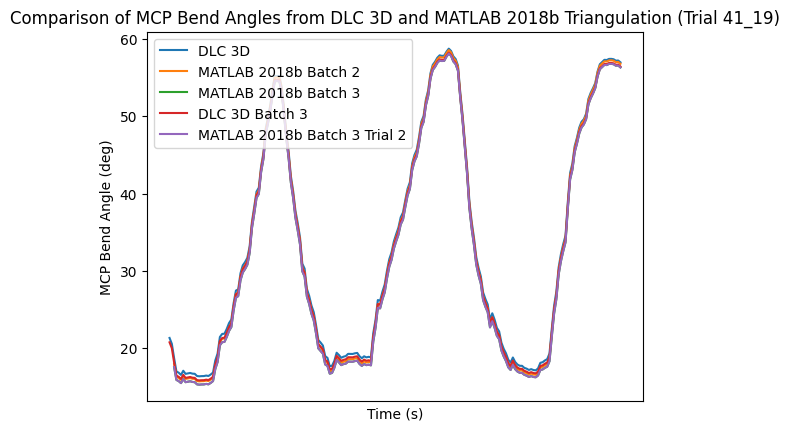

In [ ]:
# 41_19 data
dlc_data_41_19 = CameraData(
    '/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/videos_DLCpred/2025_09_09_12_41_19_B_DLC_3D.csv',
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_12_41_19_B/flir_data_2025_09_09_12_41_19_B.mat")

matlab2018_41_19 = CameraData( # batch 2 data
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/matlab2018b_triangulated_batch2/matlab2018b_triangulated_3D_points_41_19.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_12_41_19_B/flir_data_2025_09_09_12_41_19_B.mat")

matlab2018_41_19_batch3 = CameraData( # a subset of images used by DLC, naming this batch 3
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/matlab2018b_batch3/matlab2018_DLCimgs_triangulated_3D_points_41_19.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_12_41_19_B/flir_data_2025_09_09_12_41_19_B.mat")

dlc_data_41_19_batch3 = CameraData(
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/DLC_calibrated_batch3/2025_09_09_12_41_19_B_DLC_3D.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_12_41_19_B/flir_data_2025_09_09_12_41_19_B.mat")

matlab2018_41_19_batch3_trial2 = CameraData( # a subset of images used by DLC, naming this batch 3
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/MATLAB_batch3_trial2/matlab2018batch3_trial2_triangulated_3D_points_41_19.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_12_41_19_B/flir_data_2025_09_09_12_41_19_B.mat")

# overlay the past two plots
plt.plot(dlc_data_41_19.timestamps, dlc_data_41_19.mcp_bend_angles)
plt.plot(matlab2018_41_19.timestamps, matlab2018_41_19.mcp_bend_angles)
plt.plot(matlab2018_41_19_batch3.timestamps, matlab2018_41_19_batch3.mcp_bend_angles)
plt.plot(dlc_data_41_19_batch3.timestamps, dlc_data_41_19_batch3.mcp_bend_angles)
plt.plot(matlab2018_41_19_batch3_trial2.timestamps, matlab2018_41_19_batch3_trial2.mcp_bend_angles)
plt.xlabel("Time (s)")
plt.xticks([])
plt.ylabel("MCP Bend Angle (deg)")
plt.title("Comparison of MCP Bend Angles from DLC 3D and MATLAB 2018b Triangulation (Trial 41_19)")
plt.legend(["DLC 3D", "MATLAB 2018b Batch 2", "MATLAB 2018b Batch 3", "DLC 3D Batch 3", "MATLAB 2018b Batch 3 Trial 2"])
plt.show()
# hide x timestamps

# if last two the same (same set of calib images), that means calibration and triangulation algs are the same across MATLAB and DLC
# if 3rd and 5th the same, that means the 2D position predictions resulting from 4th didn't change

In [100]:
pairwise_angular_errors(
    [dlc_data_41_19.mcp_bend_angles, matlab2018_41_19.mcp_bend_angles, matlab2018_41_19_batch3.mcp_bend_angles, dlc_data_41_19_batch3.mcp_bend_angles, matlab2018_41_19_batch3_trial2.mcp_bend_angles],
    list_of_labels=["DLC 3D", "MATLAB 2018b Batch 2", "MATLAB 2018b Batch 3", "DLC 3D Batch 3", "MATLAB 2018b Batch 3 Trial 2"]
)

Mean angle error (º) between DLC 3D and MATLAB 2018b Batch 2: 0.45 ± 0.17
Mean angle error (º) between DLC 3D and MATLAB 2018b Batch 3: 0.90 ± 0.14
Mean angle error (º) between DLC 3D and DLC 3D Batch 3: 0.50 ± 0.05
Mean angle error (º) between DLC 3D and MATLAB 2018b Batch 3 Trial 2: 0.90 ± 0.14
Mean angle error (º) between MATLAB 2018b Batch 2 and MATLAB 2018b Batch 3: 0.44 ± 0.06
Mean angle error (º) between MATLAB 2018b Batch 2 and DLC 3D Batch 3: 0.18 ± 0.10
Mean angle error (º) between MATLAB 2018b Batch 2 and MATLAB 2018b Batch 3 Trial 2: 0.44 ± 0.06
Mean angle error (º) between MATLAB 2018b Batch 3 and DLC 3D Batch 3: 0.39 ± 0.16
Mean angle error (º) between MATLAB 2018b Batch 3 and MATLAB 2018b Batch 3 Trial 2: 0.00 ± 0.00
Mean angle error (º) between DLC 3D Batch 3 and MATLAB 2018b Batch 3 Trial 2: 0.39 ± 0.16


[(('DLC 3D', 'MATLAB 2018b Batch 2'),
  (np.float64(0.45445983343589874), np.float64(0.17007175907243205))),
 (('DLC 3D', 'MATLAB 2018b Batch 3'),
  (np.float64(0.8977443394606018), np.float64(0.1430078636352315))),
 (('DLC 3D', 'DLC 3D Batch 3'),
  (np.float64(0.5048898923458565), np.float64(0.050850436634456285))),
 (('DLC 3D', 'MATLAB 2018b Batch 3 Trial 2'),
  (np.float64(0.897760175283652), np.float64(0.1430108009335881))),
 (('MATLAB 2018b Batch 2', 'MATLAB 2018b Batch 3'),
  (np.float64(0.4432845060247031), np.float64(0.06306915977237987))),
 (('MATLAB 2018b Batch 2', 'DLC 3D Batch 3'),
  (np.float64(0.18054471234198638), np.float64(0.09665250394618868))),
 (('MATLAB 2018b Batch 2', 'MATLAB 2018b Batch 3 Trial 2'),
  (np.float64(0.44330034184775347), np.float64(0.06305065485230583))),
 (('MATLAB 2018b Batch 3', 'DLC 3D Batch 3'),
  (np.float64(0.3934857131851488), np.float64(0.15959367807199912))),
 (('MATLAB 2018b Batch 3', 'MATLAB 2018b Batch 3 Trial 2'),
  (np.float64(0.00018

DataFrame 1: 197 rows
DataFrame 2: 197 rows
DataFrame 1: 197 rows
DataFrame 2: 197 rows
DataFrame 1: 197 rows
DataFrame 2: 197 rows
DataFrame 1: 197 rows
DataFrame 2: 197 rows
DataFrame 1: 197 rows
DataFrame 2: 197 rows


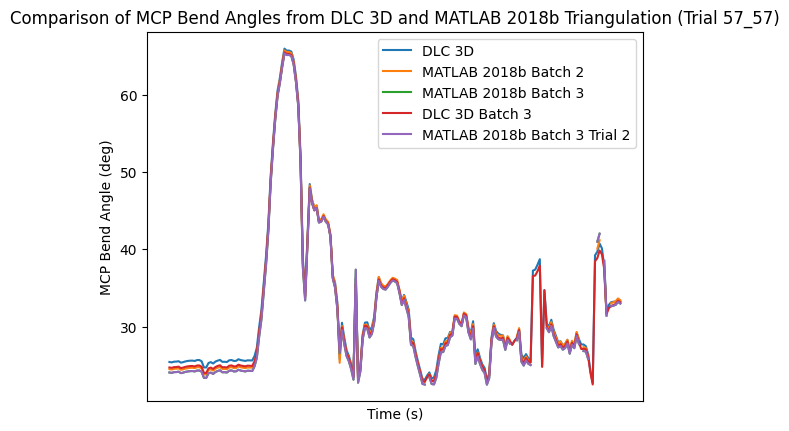

In [88]:
# 57_57 data
dlc_data_57_57 = CameraData(
    '/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/videos_DLCpred/2025_09_09_12_57_57_B_DLC_3D.csv',
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_12_57_57_B/flir_data_2025_09_09_12_57_57_B.mat")

matlab2018_57_57 = CameraData( # batch 2 data
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/matlab2018b_triangulated_batch2/matlab2018b_triangulated_3D_points_57_57.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_12_57_57_B/flir_data_2025_09_09_12_57_57_B.mat")

matlab2018_57_57_batch3 = CameraData( # a subset of images used by DLC, naming this batch 3
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/matlab2018b_batch3/matlab2018_DLCimgs_triangulated_3D_points_57_57.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_12_57_57_B/flir_data_2025_09_09_12_57_57_B.mat")

dlc_data_57_57_batch3 = CameraData(
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/DLC_calibrated_batch3/2025_09_09_12_57_57_B_DLC_3D.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_12_57_57_B/flir_data_2025_09_09_12_57_57_B.mat")

matlab2018_57_57_batch3_trial2 = CameraData( # a subset of images used by DLC, naming this batch 3
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/MATLAB_batch3_trial2/matlab2018batch3_trial2_triangulated_3D_points_57_57.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_12_57_57_B/flir_data_2025_09_09_12_57_57_B.mat")

# overlay the past two plots
plt.plot(dlc_data_57_57.timestamps, dlc_data_57_57.mcp_bend_angles)
plt.plot(matlab2018_57_57.timestamps, matlab2018_57_57.mcp_bend_angles)
plt.plot(matlab2018_57_57_batch3.timestamps, matlab2018_57_57_batch3.mcp_bend_angles)
plt.plot(dlc_data_57_57_batch3.timestamps, dlc_data_57_57_batch3.mcp_bend_angles)
plt.plot(matlab2018_57_57_batch3_trial2.timestamps, matlab2018_57_57_batch3_trial2.mcp_bend_angles)
plt.xlabel("Time (s)")
plt.xticks([])
plt.ylabel("MCP Bend Angle (deg)")
plt.title("Comparison of MCP Bend Angles from DLC 3D and MATLAB 2018b Triangulation (Trial 57_57)")
plt.legend(["DLC 3D", "MATLAB 2018b Batch 2", "MATLAB 2018b Batch 3", "DLC 3D Batch 3", "MATLAB 2018b Batch 3 Trial 2"])
plt.show()
# hide x timestamps

In [99]:
pairwise_angular_errors(
    [dlc_data_57_57.mcp_bend_angles, matlab2018_57_57.mcp_bend_angles, dlc_data_57_57_batch3.mcp_bend_angles, matlab2018_57_57_batch3.mcp_bend_angles, matlab2018_41_19_batch3_trial2.mcp_bend_angles],
    list_of_labels=["DLC 3D", "MATLAB 2018b Batch 2", "MATLAB 2018b Batch 3", "DLC 3D Batch 3", "MATLAB 2018b Batch 3 Trial 2"]
)

Mean angle error (º) between DLC 3D and MATLAB 2018b Batch 2: 0.40 ± 0.31
Mean angle error (º) between DLC 3D and MATLAB 2018b Batch 3: 0.45 ± 0.24
Mean angle error (º) between DLC 3D and DLC 3D Batch 3: 0.79 ± 0.39


ValueError: operands could not be broadcast together with shapes (197,) (198,) 

In [91]:
# 57_57 data
dlc_data_06_49 = CameraData(
    '/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/videos_DLCpred/2025_09_09_13_06_49_R_DLC_3D.csv',
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_13_06_49_R/flir_data_2025_09_09_13_06_49_R.mat")

matlab2018_06_49 = CameraData( # batch 2 data
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/matlab2018b_triangulated_batch2/matlab2018b_triangulated_3D_points_06_49.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_13_06_49_R/flir_data_2025_09_09_13_06_49_R.mat")

matlab2018_57_57_batch3 = CameraData( # a subset of images used by DLC, naming this batch 3
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/matlab2018b_batch3/matlab2018_DLCimgs_triangulated_3D_points_57_57.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_13_06_49_R/flir_data_2025_09_09_13_06_49_R.mat")

dlc_data_06_49_batch3 = CameraData(
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/DLC_calibrated_batch3/2025_09_09_13_06_49_R_DLC_3D.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_13_06_49_R/flir_data_2025_09_09_13_06_49_R.mat")

matlab2018_06_49_batch3_trial2 = CameraData( # a subset of images used by DLC, naming this batch 3
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/matlab_2018b_triangulation/MATLAB_batch3_trial2/matlab2018batch3_trial2_triangulated_3D_points_06_49.csv",
    "/Volumes/ExtremeSSD/SNEL/camera_data/09_09_SEN1_cleaned/sensor_data_for_graph/2025_09_09_13_06_49_R/flir_data_2025_09_09_13_06_49_R.mat")

# overlay the past two plots
plt.plot(dlc_data_06_49.timestamps, dlc_data_06_49.mcp_bend_angles)
plt.plot(matlab2018_06_49.timestamps, matlab2018_06_49.mcp_bend_angles)
plt.plot(matlab2018_06_49_batch3.timestamps, matlab2018_06_49_batch3.mcp_bend_angles)
plt.plot(dlc_data_06_49_batch3.timestamps, dlc_data_06_49_batch3.mcp_bend_angles)
plt.plot(matlab2018_06_49_batch3_trial2.timestamps, matlab2018_06_49_batch3_trial2.mcp_bend_angles)
plt.xlabel("Time (s)")
plt.xticks([])
plt.ylabel("MCP Bend Angle (deg)")
plt.title("Comparison of MCP Bend Angles from DLC 3D and MATLAB 2018b Triangulation (Trial 06_49)")
plt.legend(["DLC 3D", "MATLAB 2018b Batch 2", "MATLAB 2018b Batch 3", "DLC 3D Batch 3", "MATLAB 2018b Batch 3 Trial 2"])
plt.show()
# hide x timestamps

DataFrame 1: 198 rows
DataFrame 2: 198 rows
DataFrame 1: 198 rows
DataFrame 2: 198 rows
DataFrame 1: 197 rows
DataFrame 2: 198 rows


ValueError: Row count mismatch: self.df has 197 rows, other_df has 198 rows

In [75]:
threeway_pairwise_angular_errors(dlc_data_06_49.mcp_bend_angles, matlab2018_06_49.mcp_bend_angles, matlab2018_06_49_batch3.mcp_bend_angles, list_of_labels=["DLC 3D Batch 3", "MATLAB 2018b Batch 2", "MATLAB 2018b Batch 3"])

Mean angle errors (º): DLC 3D Batch 3 vs MATLAB 2018b Batch 2: 0.60 ± 0.28,
 DLC 3D Batch 3 vs MATLAB 2018b Batch 3: 0.72 ± 0.24,
 MATLAB 2018b Batch 2 vs MATLAB 2018b Batch 3: 0.18 ± 0.10


((np.float64(0.5986961704195788), np.float64(0.27794760172382965)),
 (np.float64(0.7181423834079433), np.float64(0.24338373593940119)),
 (np.float64(0.1754618156922895), np.float64(0.10467957258354546)))

In [55]:
angular_error(dlc_data_06_49.mcp_bend_angles, matlab2018_06_49.mcp_bend_angles)
print("(for where confidence > 0.6)")

Mean angle error: 0.5986961704195788 º
Standard Dev: 0.27794760172382965 º
(for where confidence > 0.6)


In [301]:
#load DLC 3d coordinates from DLC triangulation
cam = DLC3DBendAngles(cam)

# Load only variables starting with 'ts' -> timestamp data
df_ts = cam.load_mat_as_df(cam_timestamp, prefix="ts")

In [302]:
#check number of rows from  cam dataframe (taken from DLC csv) and df_ts dataframe (timestamps form flir_data.mat file).  They hopefully are the same.  If not, need to determine which frames dropped.
rows_renc, rows_cam = DLC3DBendAngles.compare_row_counts(cam.df, df_ts)

DataFrame 1: 199 rows
DataFrame 2: 199 rows


In [303]:
#add camera timestamp columns to 3d dlc data
cam.add_dataframe(df_ts)

scorer     DLC_3D                                               \
    bodyparts        PIP                               MCP              
       coords          x          y           z          x          y   
0           0        NaN        NaN         NaN -14.211303 -25.045929   
1           1        NaN        NaN         NaN -14.264890 -25.083250   
2           2 -56.100966 -38.319792  208.041883 -14.097394 -24.976217   
3           3 -56.106383 -38.250417  208.044584 -14.090106 -24.976376   
4           4 -56.089190 -38.149814  208.139745 -14.087946 -25.030933   
..        ...        ...        ...         ...        ...        ...   
194       194 -57.290142 -39.759564  208.494445 -15.360416 -26.125422   
195       195 -57.344342 -39.806411  208.596606 -15.438878 -26.199116   
196       196 -57.295183 -39.930109  208.374085 -15.392524 -26.230686   
197       197 -57.221892 -39.682812  208.506042 -15.303029 -25.978801   
198       198 -57.165121 -39.667230  208.400597 -15.238428 -25.947520   

                                                                         \
                     hand                        radius_styloid_process   
              z         x          y           z                      x   
0    223.089256 -1.135550 -19.686764  227.539939              49.256367   
1    223.105640 -1.216009 -19.760697  227.525510              49.183183   
2    223.136606 -0.983569 -19.608980  227.569830              49.436433   
3    223.091225 -0.959067 -19.578975  227.509524              49.442946   
4    223.018604 -0.931776 -19.523596  227.528141              49.478903   
..          ...       ...        ...         ...                    ...   
194  223.048980 -2.322257 -20.477405  227.456798              47.968667   
195  223.063828 -2.400470 -20.542915  227.501365              47.926570   
196  222.982048 -2.379879 -20.617186  227.371424              47.961692   
197  223.132879 -2.255357 -20.385384  227.438814              48.025273   
198  223.089658 -2.190080 -20.392521  227.354043              48.089222   

                                                             ts_25183199  \
                             forearm                                       
            y           z          x         y           z                 
0   -8.205395  224.613985  86.626535  3.879564  231.295143  183711125116   
1   -8.336508  224.614815  86.514987  3.540947  231.266235  183711173552   
2   -8.222439  224.730262  86.756038  3.633679  231.380785  183711226773   
3   -8.214810  224.688987  86.914360  3.776216  231.506675  183711277172   
4   -8.164095  224.693425  86.946188  3.833138  231.524754  183711324910   
..        ...         ...        ...       ...         ...           ...   
194 -8.811523  224.012746  85.330721  3.438371  230.255419  183720904685   
195 -8.966108  224.105062  85.091059  3.171857  230.186706  183720951743   
196 -8.976868  224.007489  85.280187  3.285432  230.290732  183721012779   
197 -8.669406  224.043278  85.368197  3.556390  230.363461  183721052240   
198 -8.557952  223.963645  85.382698  3.675112  230.182725  183721105458   

      ts_25185174  
                   
                   
0    183711132531  
1    183711184545  
2    183711236200  
3    183711286935  
4    183711332506  
..            ...  
194  183720914406  
195  183720959919  
196  183721020263  
197  183721059501  
198  183721112448  

[199 rows x 18 columns]

## Bend Angle obtained from Dot Product Formula

## $\theta = \cos^{-1} \left( \frac{\mathbf{v}_1 \cdot \mathbf{v}_2}{\|\mathbf{v}_1\| \, \|\mathbf{v}_2\|} \right)$

As an example:  

V1 is vector from hand to MCP (vector obtained from subtracting 2 xyz points from triangulated DLC csv data)

V2 is vector from MCP to PIP (vector obtained from subtracting 2 xyz points from triangulated DLC csv data)


In [304]:
#Calculte bend angles from DLC 3d trianglulated data

# --- MCP bend ---
hand_pts = cam.get_points("hand")
mcp_pts  = cam.get_points("MCP")
pip_pts  = cam.get_points("PIP")

v1_mcp = cam.vector(hand_pts, mcp_pts)  # hand→MCP
v2_mcp = cam.vector(mcp_pts, pip_pts)   # MCP→PIP
ref = np.array([0,0,1])
angles_mcp = cam.angle_from_vectors(v1_mcp, v2_mcp, signed_angles, ref)
# angles_mcp = cam.angle_from_vectors(v1_mcp, v2_mcp)

# --- Wrist angle ---
forearm_pts = cam.get_points("forearm")
hand_pts = cam.get_points("hand")
mcp_pts = cam.get_points("MCP")

v1_wrist = cam.vector(forearm_pts, hand_pts)  # forearm→hand
v2_wrist = cam.vector(hand_pts, mcp_pts)      # hand→MCP
angles_wrist = cam.angle_from_vectors(v1_wrist, v2_wrist)

# --- Add both angles to a copy of the DataFrame ---
df_out = cam.df.copy()
df_out[("metric", "mcp_bend_deg", "deg")]   = angles_mcp
df_out[("metric", "wrist_bend_deg", "deg")] = angles_wrist

cam.add_dataframe(df_out)



scorer     DLC_3D                                               \
    bodyparts        PIP                               MCP              
       coords          x          y           z          x          y   
0           0        NaN        NaN         NaN -14.211303 -25.045929   
1           1        NaN        NaN         NaN -14.264890 -25.083250   
2           2 -56.100966 -38.319792  208.041883 -14.097394 -24.976217   
3           3 -56.106383 -38.250417  208.044584 -14.090106 -24.976376   
4           4 -56.089190 -38.149814  208.139745 -14.087946 -25.030933   
..        ...        ...        ...         ...        ...        ...   
194       194 -57.290142 -39.759564  208.494445 -15.360416 -26.125422   
195       195 -57.344342 -39.806411  208.596606 -15.438878 -26.199116   
196       196 -57.295183 -39.930109  208.374085 -15.392524 -26.230686   
197       197 -57.221892 -39.682812  208.506042 -15.303029 -25.978801   
198       198 -57.165121 -39.667230  208.400597 -15.238428 -25.947520   

                                                                         \
                     hand                        radius_styloid_process   
              z         x          y           z                      x   
0    223.089256 -1.135550 -19.686764  227.539939              49.256367   
1    223.105640 -1.216009 -19.760697  227.525510              49.183183   
2    223.136606 -0.983569 -19.608980  227.569830              49.436433   
3    223.091225 -0.959067 -19.578975  227.509524              49.442946   
4    223.018604 -0.931776 -19.523596  227.528141              49.478903   
..          ...       ...        ...         ...                    ...   
194  223.048980 -2.322257 -20.477405  227.456798              47.968667   
195  223.063828 -2.400470 -20.542915  227.501365              47.926570   
196  222.982048 -2.379879 -20.617186  227.371424              47.961692   
197  223.132879 -2.255357 -20.385384  227.438814              48.025273   
198  223.089658 -2.190080 -20.392521  227.354043              48.089222   

                                                             ts_25183199  \
                             forearm                                       
            y           z          x         y           z                 
0   -8.205395  224.613985  86.626535  3.879564  231.295143  183711125116   
1   -8.336508  224.614815  86.514987  3.540947  231.266235  183711173552   
2   -8.222439  224.730262  86.756038  3.633679  231.380785  183711226773   
3   -8.214810  224.688987  86.914360  3.776216  231.506675  183711277172   
4   -8.164095  224.693425  86.946188  3.833138  231.524754  183711324910   
..        ...         ...        ...       ...         ...           ...   
194 -8.811523  224.012746  85.330721  3.438371  230.255419  183720904685   
195 -8.966108  224.105062  85.091059  3.171857  230.186706  183720951743   
196 -8.976868  224.007489  85.280187  3.285432  230.290732  183721012779   
197 -8.669406  224.043278  85.368197  3.556390  230.363461  183721052240   
198 -8.557952  223.963645  85.382698  3.675112  230.182725  183721105458   

      ts_25185174       metric                 
                  mcp_bend_deg wrist_bend_deg  
                           deg            deg  
0    183711132531          NaN      16.710271  
1    183711184545          NaN      16.679636  
2    183711236200    -4.663110      16.648860  
3    183711286935    -4.835334      16.487172  
4    183711332506    -5.227449      16.880844  
..            ...          ...            ...  
194  183720914406    -5.253924      17.426409  
195  183720959919    -5.268915      17.636108  
196  183721020263    -5.105827      17.300952  
197  183721059501    -5.080340      16.929358  
198  183721112448    -5.000774      16.758955  

[199 rows x 20 columns]

In [305]:
# Count how many NAN's in MCP Bend Angle ->  max should be size of number of timestamps from camera data 

col_name = ("metric", "mcp_bend_deg", "deg")  # tuple key in MultiIndex

# Count NaNs
num_nans = cam.df[col_name].isna().sum()

# Count total rows
total_rows = len(cam.df)

# Print results
print(f"NaNs in MCP bend angle: {num_nans} / {total_rows} rows")
print(f"Percent missing: {100 * num_nans / total_rows:.2f}%")

NaNs in MCP bend angle: 8 / 199 rows
Percent missing: 4.02%


In [306]:
cam.df

scorer     DLC_3D                                               \
    bodyparts        PIP                               MCP              
       coords          x          y           z          x          y   
0           0        NaN        NaN         NaN -14.211303 -25.045929   
1           1        NaN        NaN         NaN -14.264890 -25.083250   
2           2 -56.100966 -38.319792  208.041883 -14.097394 -24.976217   
3           3 -56.106383 -38.250417  208.044584 -14.090106 -24.976376   
4           4 -56.089190 -38.149814  208.139745 -14.087946 -25.030933   
..        ...        ...        ...         ...        ...        ...   
194       194 -57.290142 -39.759564  208.494445 -15.360416 -26.125422   
195       195 -57.344342 -39.806411  208.596606 -15.438878 -26.199116   
196       196 -57.295183 -39.930109  208.374085 -15.392524 -26.230686   
197       197 -57.221892 -39.682812  208.506042 -15.303029 -25.978801   
198       198 -57.165121 -39.667230  208.400597 -15.238428 -25.947520   

                                                                         \
                     hand                        radius_styloid_process   
              z         x          y           z                      x   
0    223.089256 -1.135550 -19.686764  227.539939              49.256367   
1    223.105640 -1.216009 -19.760697  227.525510              49.183183   
2    223.136606 -0.983569 -19.608980  227.569830              49.436433   
3    223.091225 -0.959067 -19.578975  227.509524              49.442946   
4    223.018604 -0.931776 -19.523596  227.528141              49.478903   
..          ...       ...        ...         ...                    ...   
194  223.048980 -2.322257 -20.477405  227.456798              47.968667   
195  223.063828 -2.400470 -20.542915  227.501365              47.926570   
196  222.982048 -2.379879 -20.617186  227.371424              47.961692   
197  223.132879 -2.255357 -20.385384  227.438814              48.025273   
198  223.089658 -2.190080 -20.392521  227.354043              48.089222   

                                                             ts_25183199  \
                             forearm                                       
            y           z          x         y           z                 
0   -8.205395  224.613985  86.626535  3.879564  231.295143  183711125116   
1   -8.336508  224.614815  86.514987  3.540947  231.266235  183711173552   
2   -8.222439  224.730262  86.756038  3.633679  231.380785  183711226773   
3   -8.214810  224.688987  86.914360  3.776216  231.506675  183711277172   
4   -8.164095  224.693425  86.946188  3.833138  231.524754  183711324910   
..        ...         ...        ...       ...         ...           ...   
194 -8.811523  224.012746  85.330721  3.438371  230.255419  183720904685   
195 -8.966108  224.105062  85.091059  3.171857  230.186706  183720951743   
196 -8.976868  224.007489  85.280187  3.285432  230.290732  183721012779   
197 -8.669406  224.043278  85.368197  3.556390  230.363461  183721052240   
198 -8.557952  223.963645  85.382698  3.675112  230.182725  183721105458   

      ts_25185174       metric                 
                  mcp_bend_deg wrist_bend_deg  
                           deg            deg  
0    183711132531          NaN      16.710271  
1    183711184545          NaN      16.679636  
2    183711236200    -4.663110      16.648860  
3    183711286935    -4.835334      16.487172  
4    183711332506    -5.227449      16.880844  
..            ...          ...            ...  
194  183720914406    -5.253924      17.426409  
195  183720959919    -5.268915      17.636108  
196  183721020263    -5.105827      17.300952  
197  183721059501    -5.080340      16.929358  
198  183721112448    -5.000774      16.758955  

[199 rows x 20 columns]

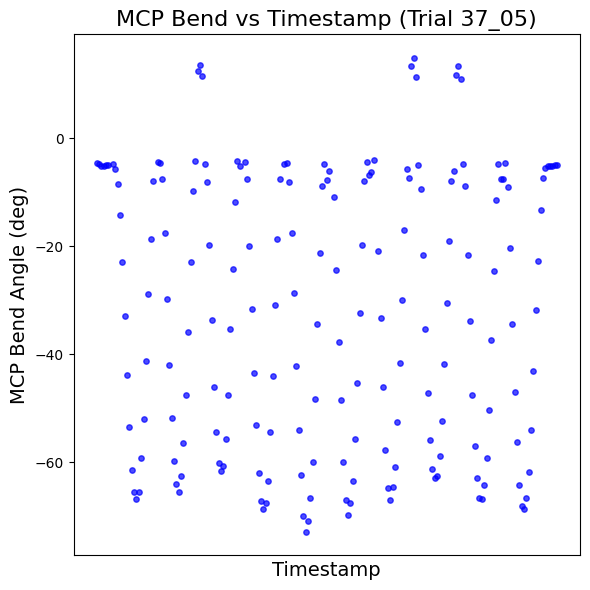

In [307]:
# Plot MCP Bend Angles Calculated from Camera Data vs Camera Timestamp
plt.figure(figsize=(6,6))
plt.scatter(
    cam.df[("ts_25183199", "", "")], 
    cam.df[("metric", "mcp_bend_deg", "deg")],
    s=15, alpha=0.7, color="blue"  # set dots to blue
)

plt.xlabel("Timestamp", fontsize=14)  # bigger label font
plt.ylabel("MCP Bend Angle (deg)", fontsize=14)

plt.title(f"MCP Bend vs Timestamp (Trial {trial_string})", fontsize=16)  # bigger title font

# Remove x ticks completely
plt.xticks([])

plt.tight_layout()
plt.savefig(os.path.join(temp_save_dir, "MCP Bend vs timestamp.png"), dpi=300, bbox_inches='tight')
plt.show()


In [308]:
df_renc.head()

,timestamp,raw,volts,angle
0,183711116203,14684,2.753250,2.635825
1,183711140863,14717,2.759438,3.016796
2,183711163313,14691,2.754563,2.716637
3,183711188072,14690,2.754375,2.705092
4,183711212366,14715,2.759063,2.993707


In [309]:
cam.df[("ts_25183199", "", "")]

0      183711125116
1      183711173552
2      183711226773
3      183711277172
4      183711324910
           ...     
194    183720904685
195    183720951743
196    183721012779
197    183721052240
198    183721105458
Name: (ts_25183199, , ), Length: 199, dtype: object

In [310]:
df_renc["timestamp"]

0      183711116203
1      183711140863
2      183711163313
3      183711188072
4      183711212366
           ...     
435    183721011690
436    183721033034
437    183721057496
438    183721079570
439    183721103034
Name: timestamp, Length: 440, dtype: int64

## Align Timestamps 

In [311]:
cam.find_matching_indices(
    encoder_df=df_renc,
    cam_time_col=("ts_25183199", "", ""),  # or "ts_25183199"
    enc_time_col="timestamp",

    #--------------- set a timestamp difference threshold here ------------------
    
    tolerance="1000ms",     # <-- was 10000; use an explicit window for clarity

    #--------------- set a timestamp difference threshold here ------------------
    
    direction="nearest",
)

cam.attach_encoder_using_match(
    encoder_df=df_renc,
    columns=None,
    suffix="_renc",
    keep_time_delta=True,
    drop_unmatched=True,
)


[find_matching_indices] Dropping 0 camera rows with NaT timestamps.
[find_matching_indices] Dropping 0 encoder rows with NaT timestamps.
[debug] cam range: 0 days 18:37:11.125116 → 0 days 18:37:21.105458
[debug] enc range: 0 days 18:37:11.116203 → 0 days 18:37:21.103034
[debug] probe |delta| (ms) stats: count    23.000000
mean      4.946000
std       3.618171
min       0.349000
25%       1.964000
50%       3.287000
75%       8.547000
max      11.453000
Name: delta_ms, dtype: float64


/Users/phily/Developer/sensorimotor-lab/Strain-Sensor-/Code/analysis/analysis.py:249: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  cam_small["_t_cam_ns"] = cam_small["t_cam_td"].view("i8")
/Users/phily/Developer/sensorimotor-lab/Strain-Sensor-/Code/analysis/analysis.py:250: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  enc_small["_t_enc_ns"] = enc_small["t_enc_td"].view("i8")


,"(scorer, bodyparts, coords)","(DLC_3D, PIP, x)","(DLC_3D, PIP, y)","(DLC_3D, PIP, z)","(DLC_3D, MCP, x)","(DLC_3D, MCP, y)","(DLC_3D, MCP, z)","(DLC_3D, hand, x)","(DLC_3D, hand, y)","(DLC_3D, hand, z)",...,"(DLC_3D, forearm, z)","(ts_25183199, , )","(ts_25185174, , )","(metric, mcp_bend_deg, deg)","(metric, wrist_bend_deg, deg)",timestamp_renc,raw_renc,volts_renc,angle_renc,time_delta_renc
0,0,NaN,NaN,NaN,-14.211303,-25.045929,223.089256,-1.135550,-19.686764,227.539939,...,231.295143,183711125116,183711132531,NaN,16.710271,183711116203,14684,2.753250,2.635825,-8.913
1,1,NaN,NaN,NaN,-14.264890,-25.083250,223.105640,-1.216009,-19.760697,227.525510,...,231.266235,183711173552,183711184545,NaN,16.679636,183711163313,14691,2.754563,2.716637,-10.239
2,2,-56.100966,-38.319792,208.041883,-14.097394,-24.976217,223.136606,-0.983569,-19.608980,227.569830,...,231.380785,183711226773,183711236200,-4.663110,16.648860,183711236999,14709,2.757938,2.924439,10.226
3,3,-56.106383,-38.250417,208.044584,-14.090106,-24.976376,223.091225,-0.959067,-19.578975,227.509524,...,231.506675,183711277172,183711286935,-4.835334,16.487172,183711281814,14717,2.759438,3.016796,4.642
4,4,-56.089190,-38.149814,208.139745,-14.087946,-25.030933,223.018604,-0.931776,-19.523596,227.528141,...,231.524754,183711324910,183711332506,-5.227449,16.880844,183711327690,14699,2.756063,2.808993,2.780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,194,-57.290142,-39.759564,208.494445,-15.360416,-26.125422,223.048980,-2.322257,-20.477405,227.456798,...,230.255419,183720904685,183720914406,-5.253924,17.426409,183720895353,14700,2.756250,2.820538,-9.332
195,195,-57.344342,-39.806411,208.596606,-15.438878,-26.199116,223.063828,-2.400470,-20.542915,227.501365,...,230.186706,183720951743,183720959919,-5.268915,17.636108,183720962731,14715,2.759063,2.993707,10.988
196,196,-57.295183,-39.930109,208.374085,-15.392524,-26.230686,222.982048,-2.379879,-20.617186,227.371424,...,230.290732,183721012779,183721020263,-5.105827,17.300952,183721011690,14728,2.761500,3.143787,-1.089
197,197,-57.221892,-39.682812,208.506042,-15.303029,-25.978801,223.132879,-2.255357,-20.385384,227.438814,...,230.363461,183721052240,183721059501,-5.080340,16.929358,183721057496,14710,2.758125,2.935984,5.256


In [312]:
# Create a smaller dataframe keeping only columns for following:

cols_to_keep = [
    ("ts_25183199", "", ""),  # camera timestamp
    "angle_renc",   
    ("metric", "mcp_bend_deg", "deg"),
    ("metric", "wrist_bend_deg", "deg"),
    "time_delta_renc",  # time difference between camera and rot enc timestamps
]
small_df = cam.df[cols_to_keep].copy()
small_df = small_df.dropna(subset=[("metric", "mcp_bend_deg", "deg")])
small_df = small_df.loc[:, ~small_df.columns.duplicated()].copy()


In [313]:
# Count how many remaining datapoints left  in MCP Bend Angle  after NaN removal from timestamped matched dataframe 

# Count NaNs
remain = len(small_df)

# Count total rows
total_rows = len(cam.df)

# Print results
print(f"Rows after timestamp matching: {total_rows} rows")
print(f"Rows after dropping NaN's in MCP Bend Angle: {remain} rows")

Rows after timestamp matching: 199 rows
Rows after dropping NaN's in MCP Bend Angle: 191 rows


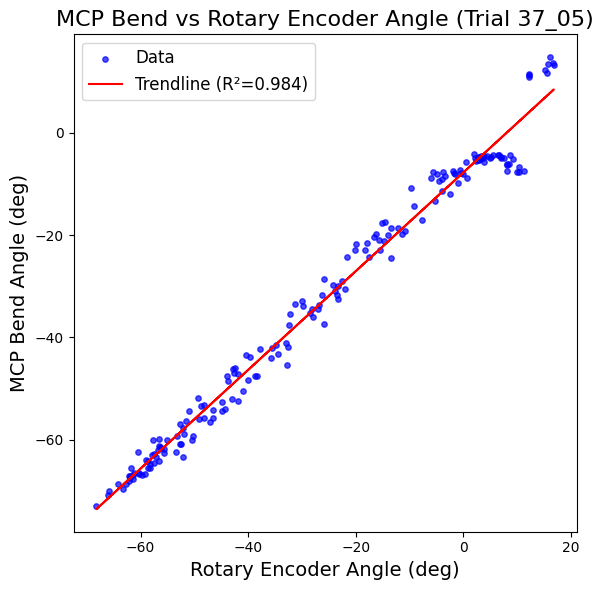

In [314]:
rot_angles = small_df["angle_renc"].to_numpy()
mcp_angles = small_df[("metric", "mcp_bend_deg", "deg")].to_numpy()

# Fit linear regression (y = m*x + b)
m, b = np.polyfit(rot_angles, mcp_angles, 1)
y_pred = m * rot_angles + b

# Compute R²
ss_res = np.sum((mcp_angles - y_pred) ** 2)
ss_tot = np.sum((mcp_angles - np.mean(mcp_angles)) ** 2)        
r2 = 1 - (ss_res / ss_tot)

# Plot
plt.figure(figsize=(6,6))
plt.scatter(rot_angles, mcp_angles, s=15, alpha=0.7, color="blue", label="Data")  # blue dots
plt.plot(rot_angles, y_pred, color="red", label=f"Trendline (R²={r2:.3f})")

plt.xlabel("Rotary Encoder Angle (deg)", fontsize=14)  # bigger labels
plt.ylabel("MCP Bend Angle (deg)", fontsize=14)
plt.title(f"MCP Bend vs Rotary Encoder Angle (Trial {trial_string})", fontsize=16)

plt.grid(False)
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig(os.path.join(temp_save_dir, "MCP Bend vs rot enc.png"), dpi=300, bbox_inches='tight')
plt.show()

In [315]:
small_df.columns

Index([            ('ts_25183199', '', ''),
                              'angle_renc',
         ('metric', 'mcp_bend_deg', 'deg'),
       ('metric', 'wrist_bend_deg', 'deg'),
                         'time_delta_renc'],
      dtype='object')

In [316]:
small_df[('metric', 'mcp_bend_deg', 'deg')]

2     -4.663110
3     -4.835334
4     -5.227449
5     -5.209144
6     -5.082170
         ...   
194   -5.253924
195   -5.268915
196   -5.105827
197   -5.080340
198   -5.000774
Name: (metric, mcp_bend_deg, deg), Length: 191, dtype: float64

# DLC data (MCP) vs Rotenc (Ground Truth)

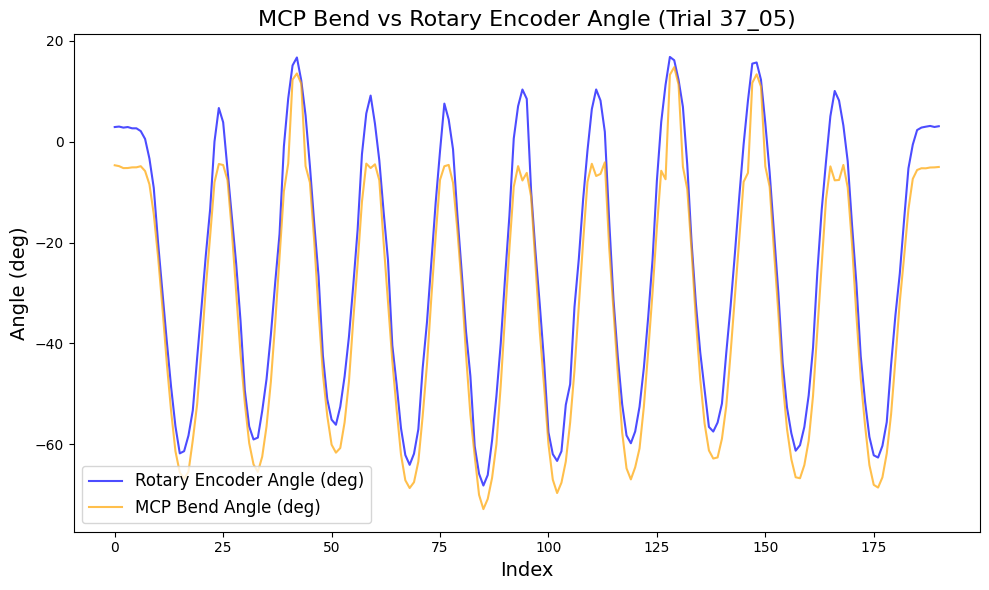

In [317]:
# Plotting DLC vs Rotary Encoder over time/index (RAW)

assert len(rot_angles) == len(mcp_angles)

# --- Plot both angles over index ---
plt.figure(figsize=(10,6))
plt.plot(rot_angles, label="Rotary Encoder Angle (deg)", color="blue", alpha=0.7)
plt.plot(mcp_angles, label="MCP Bend Angle (deg)", color="orange", alpha=0.7)
plt.xlabel("Index", fontsize=14)  # bigger label font
plt.ylabel("Angle (deg)", fontsize=14)
plt.title(f"MCP Bend vs Rotary Encoder Angle (Trial {trial_string})", fontsize=16)  # bigger title font
plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.savefig(os.path.join(temp_save_dir, "MCP Bend vs rot enc over index.png"), dpi=300, bbox_inches='tight')
plt.show()


In [318]:
# enforce rotary encoder's first time stamp to be zero, and flip sign of all values
rot_angles_tared = - (rot_angles - rot_angles[0])
if signed_angles:
    mcp_angles_tared = - (mcp_angles - mcp_angles[0])
else:
    mcp_angles_tared = mcp_angles - mcp_angles[0]

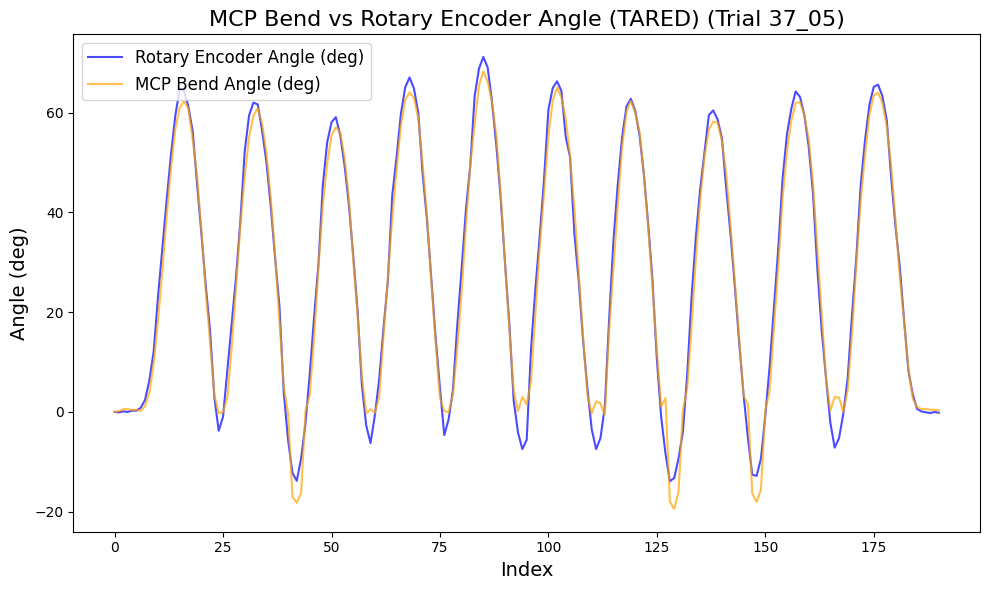

In [319]:
# Plotting DLC vs Rotary Encoder over time/index (RAW)

assert len(rot_angles) == len(mcp_angles)

# --- Plot both angles over index ---
plt.figure(figsize=(10,6))
plt.plot(rot_angles_tared, label="Rotary Encoder Angle (deg)", color="blue", alpha=0.7)
plt.plot(mcp_angles_tared, label="MCP Bend Angle (deg)", color="orange", alpha=0.7)
plt.xlabel("Index", fontsize=14)  # bigger label font
plt.ylabel("Angle (deg)", fontsize=14)
plt.title(f"MCP Bend vs Rotary Encoder Angle (TARED) (Trial {trial_string})", fontsize=16)  # bigger title font
plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.savefig(os.path.join(temp_save_dir, "MCP Bend vs rot enc over index tared.png"), dpi=300, bbox_inches='tight')
plt.show()


In [320]:
# calculate absolute angle error between tared rotary encoder and tared mcp bend angle
angle_error = np.abs(rot_angles_tared - mcp_angles_tared)
mean_error = np.mean(angle_error)
std_error = np.std(angle_error)
print("Absolute Angle Error:")
print("Mean error: ", mean_error)
print("Standard deviation: ", std_error)

Absolute Angle Error:
Mean error:  2.5716410872725985
Standard deviation:  2.1401366036623934


## Calculate Angular Error excluding regions where either graph touches or is below 0

In [321]:
valid_indices = np.where((rot_angles_tared > 0) & (mcp_angles_tared > 0))[0]
valid_indices

array([  2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  28,  29,  30,
        31,  32,  33,  34,  35,  36,  37,  38,  39,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108,
       109, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
       163, 164, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186])

Filtered Absolute Angle Error (both angles > 0):
Mean error:  2.148204940391005
Standard deviation:  1.520009267971981


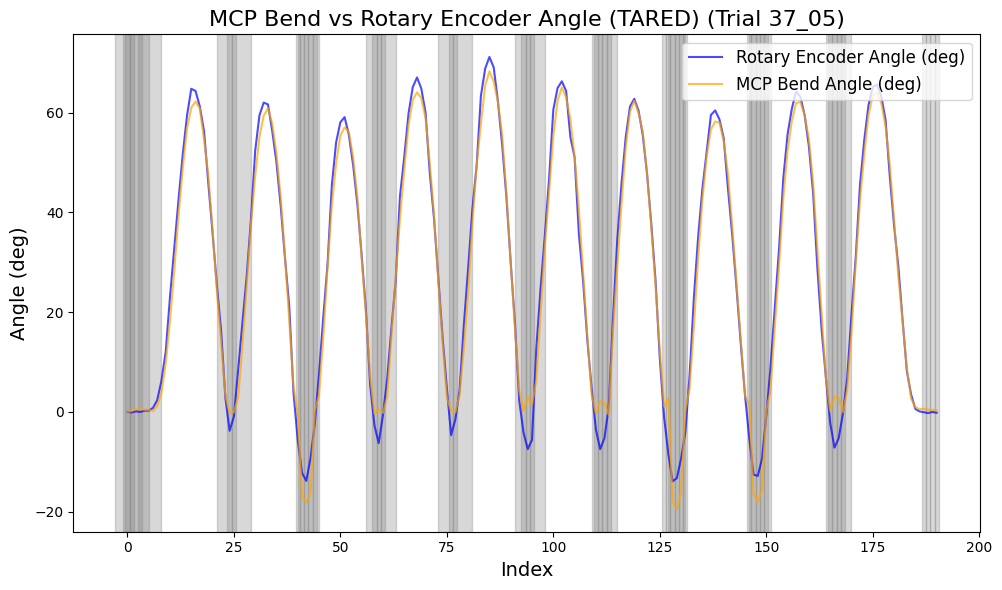

[  2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  26  27  28  29  30  31  32  33  34  35  36  37  38  39  45
  46  47  48  49  50  51  52  53  54  55  56  57  61  62  63  64  65  66
  67  68  69  70  71  72  73  74  75  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 114 115 116 117 118 119 120 121 122 123 124 125 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186]


In [322]:
## Calculate Angular Error excluding regions where either graph touches or is below 0

valid_indices = np.where((rot_angles_tared > 0) & (mcp_angles_tared > 0))[0]
filtered_rot_angles = rot_angles_tared[valid_indices]
filtered_mcp_angles = mcp_angles_tared[valid_indices]
filtered_angle_error = np.abs(filtered_rot_angles - filtered_mcp_angles)
filtered_mean_error = np.mean(filtered_angle_error)
filtered_std_error = np.std(filtered_angle_error)
print("Filtered Absolute Angle Error (both angles > 0):")
print("Mean error: ", filtered_mean_error)
print("Standard deviation: ", filtered_std_error)



# produce the same graph but shade green between peaks and valleys (also omit 5 indices around peaks/valleys)
plt.figure(figsize=(10,6))
plt.plot(rot_angles_tared, label="Rotary Encoder Angle (deg)", color="blue", alpha=0.7)
plt.plot(mcp_angles_tared, label="MCP Bend Angle (deg)", color="orange", alpha=0.7)
plt.xlabel("Index", fontsize=14)  # bigger label font
plt.ylabel("Angle (deg)", fontsize=14)
plt.title(f"MCP Bend vs Rotary Encoder Angle (TARED) (Trial {trial_string})", fontsize=16)  # bigger title font
plt.legend(fontsize=12, loc='upper right')
plt.grid(False)
plt.tight_layout()
plt.savefig("MCP Bend vs rot enc over index.png", dpi=300, bbox_inches='tight')

# shade regions where indices not valid (either angle <= 0)
in_valid_region = False
start_idx = 0
end_idx = 0
for i in range(len(rot_angles_tared)):
    if (rot_angles_tared[i] <= 0) or (mcp_angles_tared[i] <= 0):
        if not in_valid_region:
            in_valid_region = True
            start_idx = i
    else:
        if in_valid_region:
            in_valid_region = False
            end_idx = i
            plt.axvspan(start_idx+5, end_idx-5, color='gray', alpha=0.3)  # shade with some padding


# shade at indices that are not in valid_indices
for i in range(len(rot_angles_tared)):
    if i not in valid_indices:
        plt.axvspan(i-0.5, i+0.5, color='gray', alpha=0.3)  # shade with some padding

plt.savefig(os.path.join(temp_save_dir, "MCP Bend vs rot enc zero grayed.png"), dpi=300, bbox_inches='tight')
plt.show()

print(valid_indices)

In [323]:
# Print values and mask for indices 25 to 75
print("Index | rot_angles_tared | mcp_angles_tared | valid_indices")
for i in range(25, 76):
    print(f"{i:5d} | {rot_angles_tared[i]:15.4f} | {mcp_angles_tared[i]:15.4f} | {valid_indices[i]}")

Index | rot_angles_tared | mcp_angles_tared | valid_indices
   25 |         -0.9467 |         -0.0475 | 30
   26 |          8.4622 |          2.9570 | 31
   27 |         17.9865 |         12.9967 | 32
   28 |         27.1298 |         25.1520 | 33
   29 |         38.4089 |         37.4308 | 34
   30 |         52.2970 |         47.2335 | 35
   31 |         59.4316 |         55.1347 | 36
   32 |         62.0060 |         59.3664 | 37
   33 |         61.6366 |         60.8635 | 38
   34 |         56.3607 |         57.8400 | 39
   35 |         50.0343 |         51.8207 | 45
   36 |         41.2257 |         42.9606 | 46
   37 |         30.8587 |         31.2814 | 47
   38 |         21.2074 |         18.3426 | 48
   39 |          3.8444 |          5.1654 | 49
   40 |         -5.6799 |         -0.3443 | 50
   41 |        -12.2257 |        -16.9924 | 51
   42 |        -13.8073 |        -18.2185 | 52
   43 |         -9.2819 |        -16.2161 | 53
   44 |         -2.3205 |          0.1667 | 54


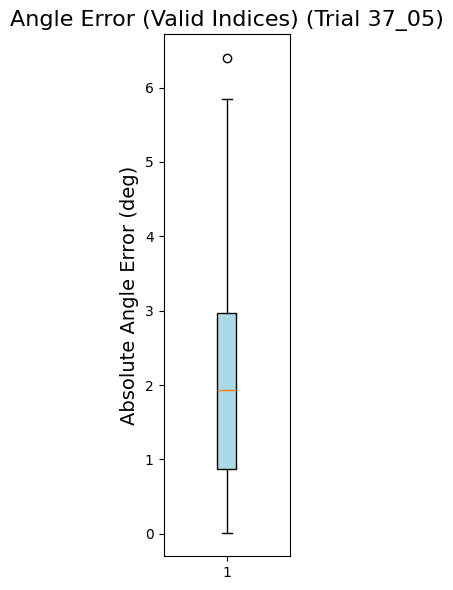

In [339]:
# create box plot for angle errors in valid indices only
plt.figure(figsize=(2,6))
plt.boxplot(filtered_angle_error, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.ylabel("Absolute Angle Error (deg)", fontsize=14)
plt.title(f"Angle Error (Valid Indices) (Trial {trial_string})", fontsize=16)
plt.grid(False)
plt.tight_layout()
plt.savefig(os.path.join(temp_save_dir, "Angle Error Box Plot Shaded by below zero.png"), dpi=300, bbox_inches='tight')
plt.show()

In [324]:
# print values of tared rotary encoder and tared mcp bend angle between indices 100 and 125
print("Tared Rotary Encoder Angles (100-125):")
print(rot_angles_tared[100:125])
print("Tared MCP Bend Angles (100-125):")
print(mcp_angles_tared[100:125])

Tared Rotary Encoder Angles (100-125):
[60.57449166 64.92680409 66.26597715 64.33802973 55.12544267 51.05020052
 35.73052252 26.1715976  14.3152982   4.64092732 -3.54419076 -7.45780858
 -5.26433547  0.95820141 18.5175309  34.2989927  45.68196369 55.05617509
 61.2094444  62.75642017 60.41286732 55.51795891 47.77153545 37.69310373
 26.31013274]
Tared MCP Bend Angles (100-125):
[55.32948527 62.38566013 65.04877145 62.99389325 58.78530105 51.08250501
 40.73243422 27.79977283 15.08156135  3.30117102 -0.29664234  2.12958591
  1.71414413 -0.58000616 16.25671101 28.75301422 41.48659675 53.02978752
 60.14363487 62.34515186 59.93731615 56.20446416 47.90005548 36.90926676
 25.24063472]


In [325]:
indices_where_true = np.where(valid_indices == True)
indices_where_true

(array([], dtype=int64),)

In [326]:
rot_angles_tared[17:98]

array([ 61.23253359,  56.23372382,  45.84358803,  35.84596848,
        25.45583269,  16.289424  ,   2.88614883,  -3.77508267,
        -0.94665682,   8.46218837,  17.98647951,  27.12979901,
        38.40886864,  52.29701681,  59.43157672,  62.00602148,
        61.63659443,  56.36071437,  50.03427613,  41.2257499 ,
        30.8587033 ,  21.20742161,   3.84435024,  -5.6799409 ,
       -12.22572645, -13.80733601,  -9.28185464,  -2.32046366,
         7.72333427,  19.15248364,  29.69269917,  45.39334881,
        54.00561692,  58.06931447,  59.08523886,  55.50641431,
        49.49168015,  41.62981073,  31.38975468,  20.41084453,
         5.39132602,  -2.68989071,  -6.24562607,  -0.65804193,
         6.60350852,  16.86665377,  26.35631112,  43.30377706,
        51.07328971,  59.76636999,  65.09997302,  67.03946504,
        64.83444733,  59.9857173 ,  47.84080302,  38.66284974,
        26.81809493,  14.97334013,   4.80255165,  -4.65247192,
        -1.4892528 ,   4.42158001,  17.42079434,  28.75

In [327]:
mcp_angles_tared[17:98]

array([ 6.08275038e+01,  5.45564309e+01,  4.74163863e+01,  3.65414546e+01,
        2.42901628e+01,  1.40357589e+01,  3.38175586e+00, -2.56194941e-01,
       -4.75240660e-02,  2.95701536e+00,  1.29967205e+01,  2.51519887e+01,
        3.74307925e+01,  4.72334703e+01,  5.51346817e+01,  5.93663996e+01,
        6.08634837e+01,  5.78399630e+01,  5.18206730e+01,  4.29606004e+01,
        3.12814133e+01,  1.83425551e+01,  5.16541183e+00, -3.44345549e-01,
       -1.69923677e+01, -1.82185393e+01, -1.62161355e+01,  1.66692392e-01,
        3.41656643e+00,  1.50673174e+01,  2.90437231e+01,  4.14296029e+01,
        4.97162718e+01,  5.54489403e+01,  5.70325712e+01,  5.61102586e+01,
        5.10197989e+01,  4.29210618e+01,  3.06539155e+01,  1.95440545e+01,
        7.24853570e+00, -3.27755863e-01,  5.55553368e-01, -1.89045890e-01,
        2.97150853e+00,  1.53442496e+01,  2.70789535e+01,  3.88044687e+01,
        4.85269961e+01,  5.73914821e+01,  6.25108442e+01,  6.40627148e+01,
        6.28996059e+01,  

## Calculate Angular Error excluding peaks

In [328]:
# calculate absolute angle error between tared rotary encoder and tared mcp bend angle, BUT only for segments between peaks
from scipy.signal import find_peaks
peaks, _ = find_peaks(rot_angles_tared, height=50, distance=5)  # adjust height and distance as needed
valleys, _ = find_peaks(-rot_angles_tared, height=0, distance=10)  # invert signal to find valleys
# valleys = []
peaks, valleys

(array([ 15,  32,  51,  68,  85, 102, 119, 138, 157, 176]),
 array([  1,  24,  42,  59,  76,  94, 111, 128, 148, 166, 188]))

In [329]:
exclude_range_for_trials = {
    "24_57": 10, # also change peak range to +6 in plt.axvspan(p-exclude_range, p+exclude_range+6, color='grey', alpha=0.5) for the below two cells
    "29_07": 10,
    "31_23": 5,
    "33_22": 2,
    "35_22": 2,
    "37_05": 1
}

exclude_range = exclude_range_for_trials[trial_string]

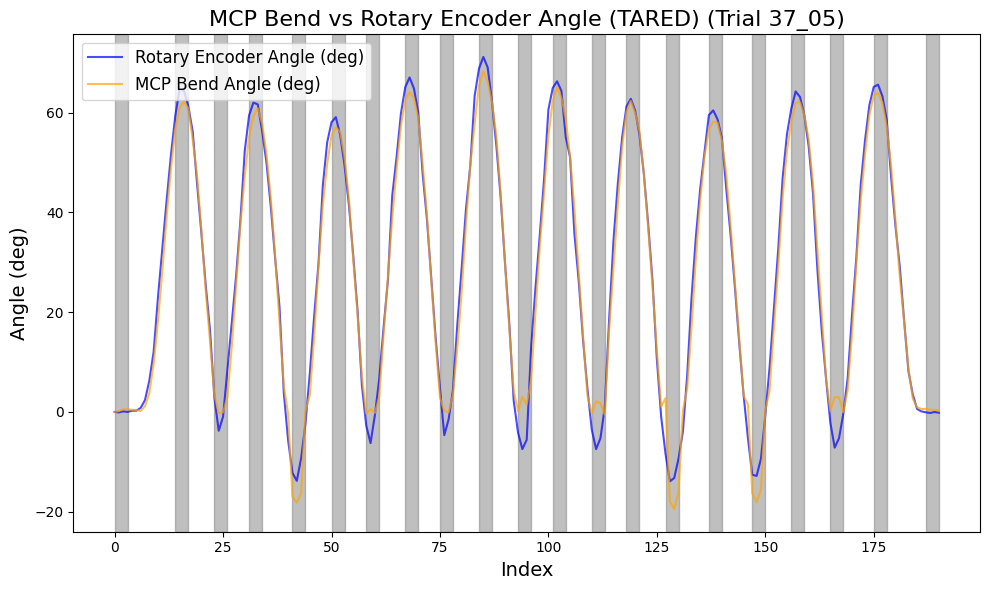

In [330]:
# produce the same graph but shade green between peaks and valleys (also omit 5 indices around peaks/valleys)
plt.figure(figsize=(10,6))
plt.plot(rot_angles_tared, label="Rotary Encoder Angle (deg)", color="blue", alpha=0.7)
plt.plot(mcp_angles_tared, label="MCP Bend Angle (deg)", color="orange", alpha=0.7)
plt.xlabel("Index", fontsize=14)  # bigger label font
plt.ylabel("Angle (deg)", fontsize=14)
plt.title(f"MCP Bend vs Rotary Encoder Angle (TARED) (Trial {trial_string})", fontsize=16)  # bigger title font
plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.savefig("MCP Bend vs rot enc over index.png", dpi=300, bbox_inches='tight')

for p in peaks:
    plt.axvspan(p-exclude_range, p+exclude_range+1, color='grey', alpha=0.5)  # omit 5 indices around peak
for v in valleys:
    plt.axvspan(v-exclude_range, v+exclude_range+1, color='grey', alpha=0.5)  # omit 5 indices around valley

plt.savefig(os.path.join(temp_save_dir, "MCP Bend vs rot enc over index tared shaded.png"), dpi=300, bbox_inches='tight')
plt.show()

In [331]:
# Angular error only between peaks and valleys (excluding 5 indices around peaks/valleys)
valid_indices = np.ones(len(rot_angles_tared), dtype=bool)
for p in peaks:
    valid_indices[max(0, p-exclude_range):min(len(rot_angles_tared), p+exclude_range+1)] = False  # exclude 5 indices around peak
for v in valleys:
    valid_indices[max(0, v-exclude_range):min(len(rot_angles_tared), v+exclude_range+1)] = False  # exclude 5 indices around valley
angle_error_peaks_valleys = angle_error[valid_indices]
mean_error_pv = np.mean(angle_error_peaks_valleys)
std_error_pv = np.std(angle_error_peaks_valleys)
print("Absolute Angle Error excluding shaded regions:")
print("Mean error: ", mean_error_pv)
print("Standard deviation: ", std_error_pv)


Absolute Angle Error excluding shaded regions:
Mean error:  2.2601456540949005
Standard deviation:  1.7155884067095648


In [332]:
# indices of tared MCP bend angles that are negative
np.sum(mcp_angles_tared < 0)
np.where(mcp_angles_tared < 0)[0]

array([ 24,  25,  40,  41,  42,  43,  58,  60,  77, 110, 113, 128, 129,
       130, 147, 148, 149, 168])

In [333]:
# print values at negative indices
mcp_angles_tared[np.where(mcp_angles_tared < 0)[0]]

array([ -0.25619494,  -0.04752407,  -0.34434555, -16.99236768,
       -18.21853926, -16.21613547,  -0.32775586,  -0.18904589,
        -0.06998342,  -0.29664234,  -0.58000616, -17.95502242,
       -19.47541748, -16.01657939, -16.35963295, -18.05391927,
       -15.62377693,  -0.06605212])

In [334]:
# get camera timestamps list
cam.df[("ts_25183199", "", "")]

0      183711125116
1      183711173552
2      183711226773
3      183711277172
4      183711324910
           ...     
194    183720904685
195    183720951743
196    183721012779
197    183721052240
198    183721105458
Name: (ts_25183199, , ), Length: 199, dtype: object

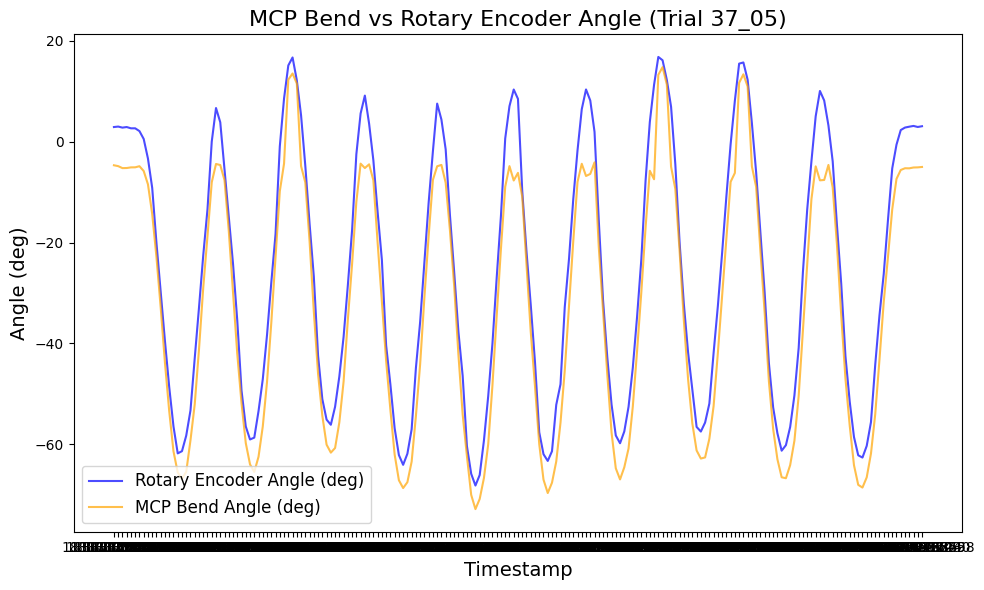

In [335]:
# --- Plot both angles over time (using camera timestamps) ---
plt.figure(figsize=(10,6))
plt.plot(small_df[("ts_25183199", "", "")], rot_angles, label="Rotary Encoder Angle (deg)", color="blue", alpha=0.7)
plt.plot(small_df[("ts_25183199", "", "")], mcp_angles, label="MCP Bend Angle (deg)", color="orange", alpha=0.7)
plt.xlabel("Timestamp", fontsize=14)  # bigger label font
plt.ylabel("Angle (deg)", fontsize=14)
plt.title(f"MCP Bend vs Rotary Encoder Angle (Trial {trial_string})", fontsize=16)  # bigger title font
plt.legend(fontsize=12)
plt.grid(False)
plt.tight_layout()
plt.savefig("MCP Bend vs rot enc over time.png", dpi=300, bbox_inches='tight')
plt.show()

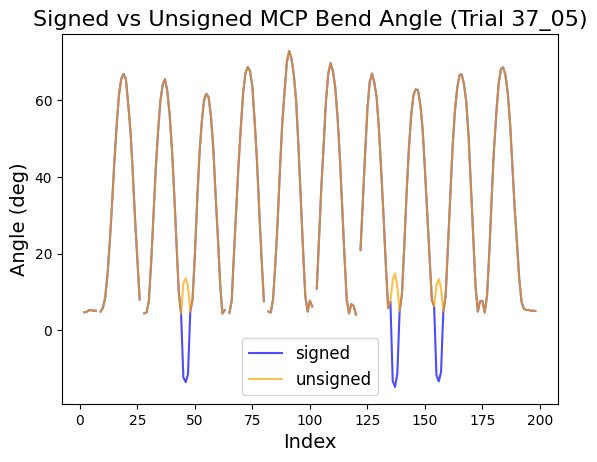

In [336]:
# debugging signed vs unsigned angle calculation accuracy
angles_mcp_signed = - cam.angle_from_vectors(v1_mcp, v2_mcp, signed=True, ref=np.array([0,0,1]))
angles_mcp_unsigned = cam.angle_from_vectors(v1_mcp, v2_mcp)

plt.plot(angles_mcp_signed, label="signed", color="blue", alpha=0.7)
plt.plot(angles_mcp_unsigned, label="unsigned", color="orange", alpha=0.7)
plt.xlabel("Index", fontsize=14)  # bigger label font
plt.ylabel("Angle (deg)", fontsize=14)
plt.title(f"Signed vs Unsigned MCP Bend Angle (Trial {trial_string})", fontsize=16)  # bigger title font
plt.legend(fontsize=12)
plt.grid(False)

# Save figures and stats

In [337]:
from PIL import Image, ImageDraw, ImageFont

# Load previously saved figures

MCP_time = Image.open(os.path.join(temp_save_dir, "MCP Bend vs timestamp.png"))
MCP_rot = Image.open(os.path.join(temp_save_dir, "MCP Bend vs rot enc.png"))
MCP_rot_index = Image.open(os.path.join(temp_save_dir, "MCP Bend vs rot enc over index.png"))
MCP_rot_index_tared = Image.open(os.path.join(temp_save_dir, "MCP Bend vs rot enc over index tared.png"))
MCP_rot_index_tared_shaded = Image.open(os.path.join(temp_save_dir, "MCP Bend vs rot enc zero grayed.png"))

# Decide layout
width = MCP_time.width + MCP_rot.width + MCP_rot_index.width + MCP_rot_index_tared.width + MCP_rot_index_tared_shaded.width
height = max(MCP_time.height, MCP_rot.height, MCP_rot_index.height, MCP_rot_index_tared.height, MCP_rot_index_tared_shaded.height) + 400  # extra space for stats

# Create a blank canvas
summary = Image.new("RGB", (width, height), "white")

# Add stats text
draw = ImageDraw.Draw(summary)
font_size = 120
font = ImageFont.truetype('/Library/Fonts/Arial.ttf', size=font_size)
stats_text = f"Trial {trial_string}:\nAbsolute Angle Error (DLC vs RotEnc): Mean={mean_error}  |  Std={std_error}            Excluding Shaded Region:   Mean={filtered_mean_error}  |  Std={filtered_std_error}\n"
draw.text((200, 50), stats_text, fill="black", font=font)

# Paste plots
summary.paste(MCP_time, (0, 350))
summary.paste(MCP_rot, (MCP_time.width, 350))
summary.paste(MCP_rot_index, (MCP_time.width + MCP_rot.width, 350))
summary.paste(MCP_rot_index_tared, (MCP_time.width + MCP_rot.width + MCP_rot_index.width, 350))
summary.paste(MCP_rot_index_tared_shaded, (MCP_time.width + MCP_rot.width + MCP_rot_index.width + MCP_rot_index_tared.width, 350))


summary.save(os.path.join(temp_save_dir, f"trial_{trial_string}_summary.png"))
summary.show()


In [338]:
first_timestamp = small_df[("ts_25183199", "", "")].iloc[0]
last_timestamp = small_df[("ts_25183199", "", "")].iloc[-1]
print(f"First timestamp: {first_timestamp}")
print(f"Last timestamp: {last_timestamp}")

First timestamp: 183711226773
Last timestamp: 183721105458
